## Impressions and Reviews  
- one of the cleanest code and kernel ever!  
  
  
cleaning  
- df.select_dtypes(include='object') or df.select_dtypes(exclude='object') 사용가능
- category컬럼의 nan과 numerical컬럼의 nan을 다르게 처리, 전자는 extra class ("None"), 후자는 평균값으로 처리
- LotFrontage는 특히 neighborhood 별 median으로 처리
  
  
EDA  
- 다중공선성(X와 y의 heatmap), 왜도(distplot), 중요 변수 및 outlier 확인(피처와 y 간에 jointplot, scatter)
  
  
Feature Engineering  
- ordinal 있으면 label_encoding, 아니면 ohe
- train, test concat 후 encoding (한쪽만 있으면 error)
- numerical중에서도 cat 변수로 적절한것은 취급
- outlier 제거, 왜도.0.75 boxcox변환, 4개 다중공선성변수 제거, numerical feature에 normalize적용
  

Modeling 및 결론  
- Lasso alpha에 대해 gridsearchCV
- 중요변수가 적을 때는 Lasso가 준수한 성능
- TotalHouse_OverallQual 가 중요변수.
- area, quality, condition 관련 변수가 중요, 그다음 ohe neiborhood

# 1 Introduction

In first place I'd like to say my notebook was inspired by many kernels that have been posted, in fact there's probably nothing here that you won't see on other kernels. My objective was to build an **effective and well documented solution that balances accuracy and interpretability**. So here you'll see some ideas and techniques that are split between other kernels, I decided not to use any extreme feature engineering, dimensionality reduction or ensembles which may increase accuracy but would reduce the interpretability of the model.

- [Data Preprocessing](#Data-Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature Engineering](#Feature-Engineering)
- [Data Cleaning](#Data-Cleaning)
- [Modelling](#Modelling)

# 2 Data Preprocessing

## 2.1 Data Loading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from scipy.stats import skew
from math import sqrt

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 300)

In [3]:
df_train = pd.read_csv("/content/train.csv", index_col="Id")
df_test = pd.read_csv("/content/test.csv", index_col="Id")
y_train = df_train.SalePrice
df_train = df_train.drop(columns='SalePrice')

print(len(df_train._get_numeric_data().columns))
print(len(df_train.select_dtypes(include='object').columns))

36
43


## 2.2 Missing Data

-  ### category컬럼의 nan과 numerical컬럼의 nan을 다르게 처리, 전자는 extra class ("None"), 후자는 평균값으로 처리
- ### LotFrontage는 특히 neighborhood 별 median으로 처리

Here the objective is to detect and handle the missing values in our data, it's important to check the dataset description. Below are some conclusions:
- The categorical NaNs are not missing values, they simply mean the house doesn't have that particular feature, this means they are an extra category. For this reason they were replaced with the category "None"
- The numerical NaNs are indeed missing values and were imputed with the mean of that particular feature.
- A particular case was with LotFrontage, insteading of imputing with the mean of the feature I imputed by using the mean of thet corresponding neighborhood.

### 2.2.1 What Data is Missing?

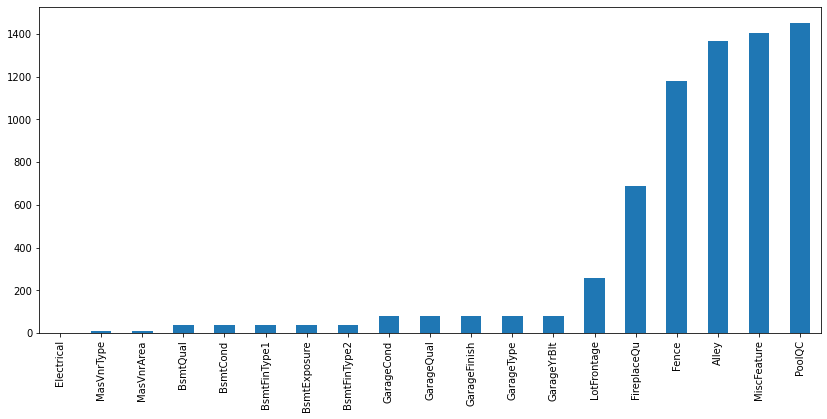

In [4]:
_, axes = plt.subplots(figsize=(14, 6))
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

### 2.2.2 Imputing Categorical Features

In [5]:
categorical_features = df_train.select_dtypes(include='object').columns
df_train[categorical_features] = df_train[categorical_features].fillna('None')
df_test[categorical_features] = df_test[categorical_features].fillna('None')

### 2.2.3 Imputing Numerical Features

In [11]:
#from sklearn.preprocessing import Imputer # 현재 deprecated
from sklearn.impute import SimpleImputer

# Replace NaN with corresponding Neighborhood Median
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
df_test["LotFrontage"] = df_test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
    
# Replace NaN with Feature Median 
numerical_features = df_train.select_dtypes(include='number').columns

# my_imputer = Imputer()
# df_train[numerical_features] = my_imputer.fit_transform(df_train[numerical_features])
# df_test[numerical_features] = my_imputer.transform(df_test[numerical_features])

# deprecated version으로 아래 코드로 대체
my_imputer = SimpleImputer(strategy='median')
df_train[numerical_features] = my_imputer.fit_transform(df_train[numerical_features])
df_test[numerical_features] = my_imputer.transform(df_test[numerical_features])

## 2.3 Categorical Encoding

- ### ordinal 있으면 label_encoding, 아니면 ohe
- ### train, test concat 후 encoding (한쪽만 있으면 error)
- ### numerical중에서도 cat 변수로 적절한것은 취급

Here the objective is to encode categorical features and also factorize numerical features that should be categorical, these are some of the conclusions reached:

- First we join the train and test sets to guarantee they'll have te same dimension, because if one of the datasets had a category that the other didn't have One-hot encoding would output train and test sets with different dimensions which would break our model.
- There are some numerical features which make more as categoricals, so they are turned into type str and then one-hot encoded
- Categorical features that have no ordinal relation in their categories are one-hot encoded
- Categorical features that have an ordinal relation in their categories are manually encoded to maintain their ordinal relation

### 2.3.1 Train-Test Join

In [12]:
idx_split = df_train.shape[0]
df_train = df_train.append(df_test)

### 2.3.2 Factorizing

In [13]:
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    df_train[col]=df_train[col].astype(str)
    
non_ordinal_features = ['LandSlope','Utilities','MSZoning', 'Street','Alley','LotShape','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle', 'RoofStyle','RoofMatl','Exterior1st', 'Exterior2nd','MasVnrType','Foundation', 'BsmtExposure','BsmtFinType1','BsmtFinType2', 'Heating', 'CentralAir', 'Electrical','Functional', 'GarageType','GarageFinish','PavedDrive', 'Fence','MiscFeature','SaleType','SaleCondition', "MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
ordinal_features = df_train.select_dtypes(include='object').columns.drop(non_ordinal_features)

### 2.3.3 Non-Ordinal Variables

In [14]:
dummies = pd.get_dummies(df_train.loc[:,non_ordinal_features], drop_first=True)
df_train = pd.concat([df_train,dummies], axis=1)
df_train = df_train.drop(non_ordinal_features,axis=1)

### 2.3.4 Ordinal Variables

In [15]:
def cat_to_num(x):
    if x=='Ex':
        return 5
    if x=='Gd':
        return 4
    if x=='TA':
        return 3
    if x=='Fa':
        return 2
    if x=='Po':
        return 1
    if x=='None':
        return 0

df_train.loc[:,ordinal_features] = df_train.loc[:,ordinal_features].applymap(cat_to_num)

### 2.3.5 Train-Test Split

In [16]:
X = df_train.loc[:idx_split, :]
X_test = df_train.loc[idx_split+1:, :]

# 3 Exploratory Data Analysis

- ### 다중공선성, 중요변수, 왜도, outlier 확인


This EDA has the objectives described below, any actions will be taken during the Data Cleaning and Feature Engineering phases.

- Get a general feel for the dataset
- Discover predictors that are correlated between them which may lead to **multicollinearity issues**
- Find out which predictors are most correlated with the target, these are the **top potential predictors** and are good candidates for feature engineering. It will also be interesting to verify if these are actually the ones the model gives more weight
- Inspect the data distributions and identify **skewed distributions** and **potential outliers** which can negatively impact the model performance

## 3.1 Predictors-Target Join
Doing EDA is easier if the predictors and the labels are in the same dataframe

In [17]:
X = X.assign(SalePrice=y_train)

## 3.2 Target Variable
The target variable is right skewed, this makes sense since expensive houses are rarer. Having skewed distributions may negatively impact model performance, so we'll take care of this during data cleaning

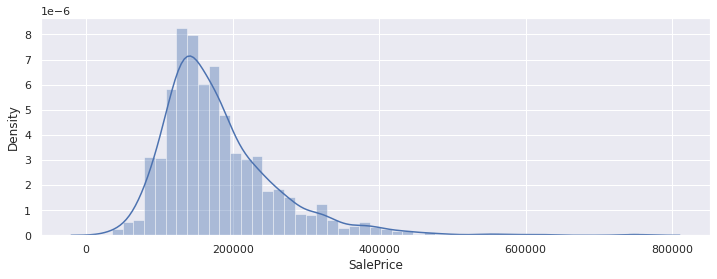

In [18]:
sns.set()
_, axes = plt.subplots(figsize=(12, 4))
sns.distplot(X.SalePrice)

## 3.3 Correlation Analysis
### 3.3.1 General Correlation
There are highly correlated features with each other this may result in multicollineariy during the modelling phase, these are the most troublesome features:
- GarageCars and GarageArea are highly correlated.
- PoolQC and PoolArea are highly correlated.
- Fireplaces and FireplaceQu are highly correlated.
- GarageCond and GarageCond are highly correlated

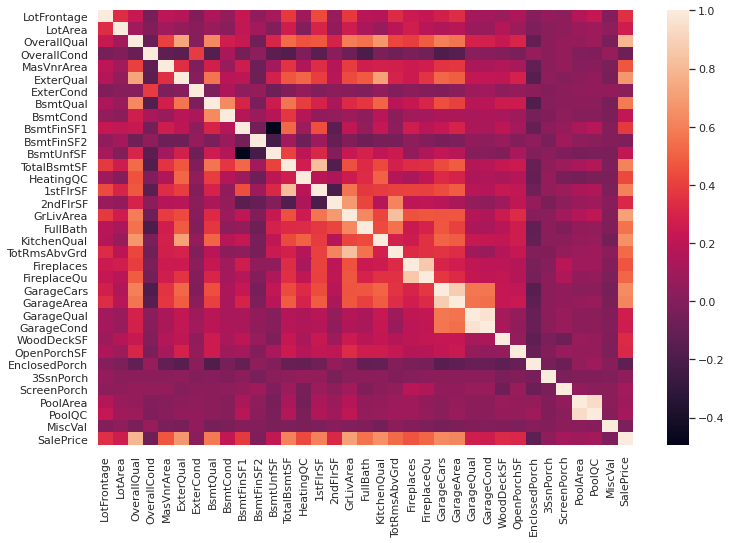

In [19]:
_, ax = plt.subplots(ncols=1, figsize=(12,8))
corr_matrix = X.drop(dummies,axis=1).corr()
sns.heatmap(corr_matrix);

### 3.3.2 Correlation with Target
Here we plot the 10 most correlated features with our target to have an idea of which might be the best predictors, below are the descriptions of the features.

1. **OverallQual:** Rating of the material and finish of the house.
2. **GrLivArea:** Above ground living area in square feet, it's basically the area of the house excluding the basement. This means that it is related with two other features in the following manner: GrLivArea = 1stFlrSF + 2ndFlrSF
3. **ExterQual:** Evaluates the quality of the material on the exterior, it's interesting that although the description is similar to OverallQual they are not very correlated as seen on the previous plot.
4. **KitchenQual:** Just the general kitchen quality.
5. **GarageCars:**  Size of garage in car capacity.
6. **GarageArea:** Size of garage in square feet, hence why it is correlated with GarageCars, they measure pretty much the same thing using different metrics.
7. **TotalBsmtSF:** Area of the Basement in square feet.
8. **1stFlrSF:** Area of the First Floor in square feet.
9. **BsmtQual:** Evaluates the height of the basement.
10. **FullBath:** Number of full bathrooms above the ground.

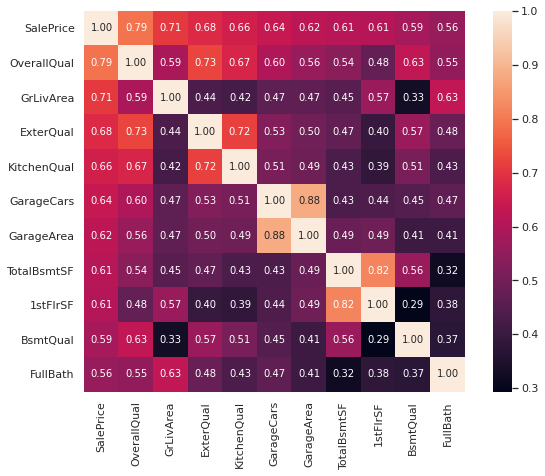

In [20]:
_, ax = plt.subplots(ncols=1, figsize=(10,7))
cols = corr_matrix.nlargest(11, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(X[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

## 3.4 Numerical Features

- ### outlier 확인, 제거 필요, 왜도 확인 및 조정

The objective here is to plot the Numerical Features in order to understand their distributions and if they have outliers, below are some of the reached conclusions:

- In most numerical features there are some outliers, in fact they are the same points for all features. This are indeed unwanted outliers as can be seen in the dataset description, so they were removed.
- There are some skewed distributions so we might have to take care of this.

### 3.4.1 OverallQual

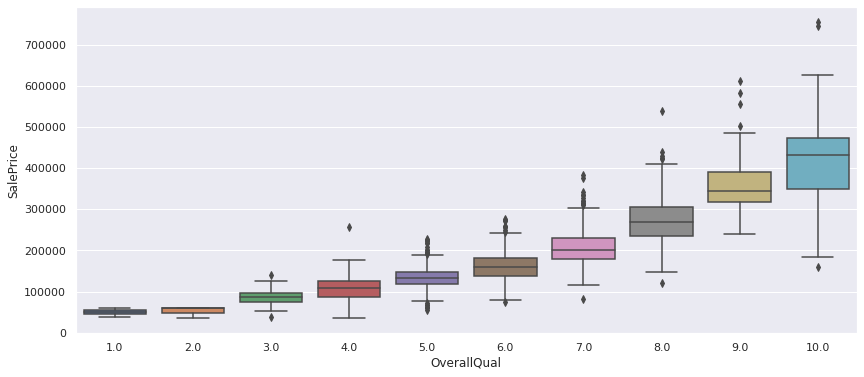

In [21]:
_, axes = plt.subplots(figsize=(14, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=X)

### 3.4.2 GrLivArea

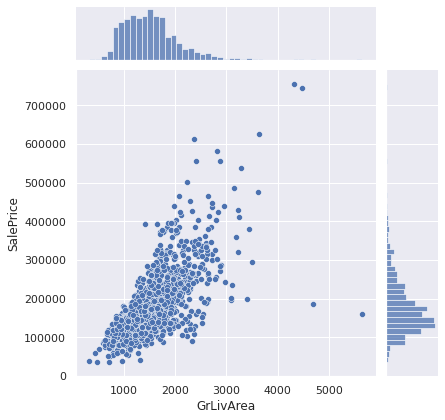

In [22]:
sns.set()
sns.jointplot(kind='scatter',data=X, x='GrLivArea', y='SalePrice')

### 3.4.3 TotalBsmtSF

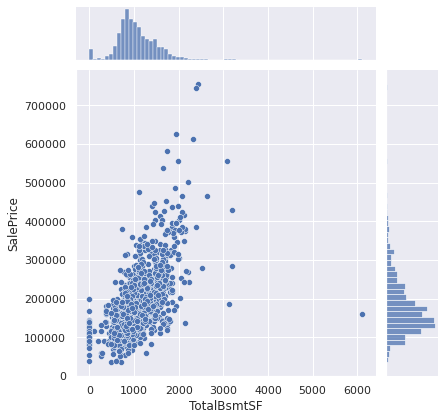

In [23]:
sns.set()
sns.jointplot(kind='scatter',data=X, x='TotalBsmtSF', y='SalePrice')

### 3.4.4  1stFlrSF

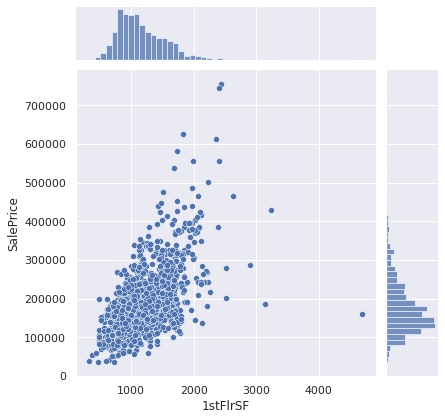

In [24]:
sns.set()
sns.jointplot(kind='scatter',data=X, x='1stFlrSF', y='SalePrice')

## 3.5 Predictors-Target Split
Here I dropped the target again, because we don't want to have our target as a predictor when we're modelling.

In [ ]:
X = X.drop(columns = ['SalePrice'])

# 4 Feature Engineering

Here the objective is to engineer some extra features to help our model understand relations between them:

- **TotalHouse:** The total area of the house including the basement
- **TotalHouse_OverallQual:** The total area of the house times the overall quality, this proved to be the most weighted feature for Lasso
- **GrLivArea_OverallQual:** The area of the house excluding the basement times the overall quality

In [34]:
X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
X["TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
X["GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]


X_test["TotalHouse"] = X_test["TotalBsmtSF"] + X_test["1stFlrSF"] + X_test["2ndFlrSF"]   
X_test["TotalHouse_OverallQual"] = X_test["TotalHouse"] * X_test["OverallQual"]
X_test["GrLivArea_OverallQual"] = X_test["GrLivArea"] * X_test["OverallQual"]


# 5 Data Cleaning

- ### outlier 제거, 왜도.0.75 boxcox변환, 4개 다중공선성변수 제거, numerical feature에 normalize적용


Here the objective is to clean the data based on the EDA we did previously, here are some conclusions:
- The previously detected outliers were removed
- All features with skewness above 0.75 are boxcox transformed
- The four multicollinear features we identified previously are removed
- All features are scaled using MinMaxScaling since it gave better results comparing to Standard and Robust

## 5.1 Handling Outliers

In [35]:
print(X[(X['GrLivArea']>4000) & (y_train<300000)].index)
X = X.drop(X[(X['GrLivArea']>4000) & (y_train<300000)].index)
y_train = y_train.drop([524, 1299])

Int64Index([524, 1299], dtype='int64', name='Id')


## 5.2 Feature Normalization

In [36]:
numeric_feats = X.dtypes[X.dtypes != "object"].index
numeric_feats = numeric_feats.drop(dummies)
numeric_feats = numeric_feats.drop(ordinal_features)

skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    X[feat] = boxcox1p(X[feat], lam)
    X_test[feat] = boxcox1p(X_test[feat], lam)

In [37]:
y_train = np.log(y_train)

## 5.3 Avoiding Multicollinearity

In [38]:
multicol_features = ['GarageCars', 'PoolQC', 'FireplaceQu', 'GarageCond']
X = X.drop(multicol_features, axis = 1)
X_test = X_test.drop(multicol_features, axis = 1)

## 5.4 Feature Scaling

In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X)

X[X.columns] = scaler.transform(X[X.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

# 6 Modelling

- 중요변수가 적을 때는 Lasso가 준수한 성능
- TotalHouse_OverallQual 가 중요변수.
- area, quality, condition 관련 변수가 중요, 그다음 ohe neiborhood

So we finally reached the modelling phase, I tried other regression models like Ridge and ElasticNet but Lasso obtained the best results, probably due to the high ammount of non-important features which Lasso handles very well.

Linear models are very easy to interpret we simply look at the weights that were assigned to each feature and we understand its influence in the predictive power of the model, below are some conclusions we can reach by looking at Lassos' coefficients:

-  The most important feature is **TotalHouse_OverallQual**, which we created. This makes sense since it account for both the area of the house and materials and finishes.
- The other top 7 features are all related with areas of the house and overall quality and condition, so these are clearly the most important features for determining the price of a house.
- Other very important features are the one-hot encoded neighborhoods, there are both positive and negative coefficients corresponding to the most and least expensive neighborhoods.

## 6.1 Lasso Regression


In [40]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error


# alpha 에 대해 gridsearch 시도

rgr_ls = Lasso(fit_intercept = True)
param_grid = {
    "alpha": [0.0002, 0.0003, 0.0005, 0.0008, 0.001]
}
searchCV = GridSearchCV(rgr_ls, cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
searchCV.fit(X, y_train)
np.sqrt(searchCV.best_score_*-1)

0.11744681277484599

Text(0.5, 1.0, 'Coefficients with magnitude greater than 0.03')

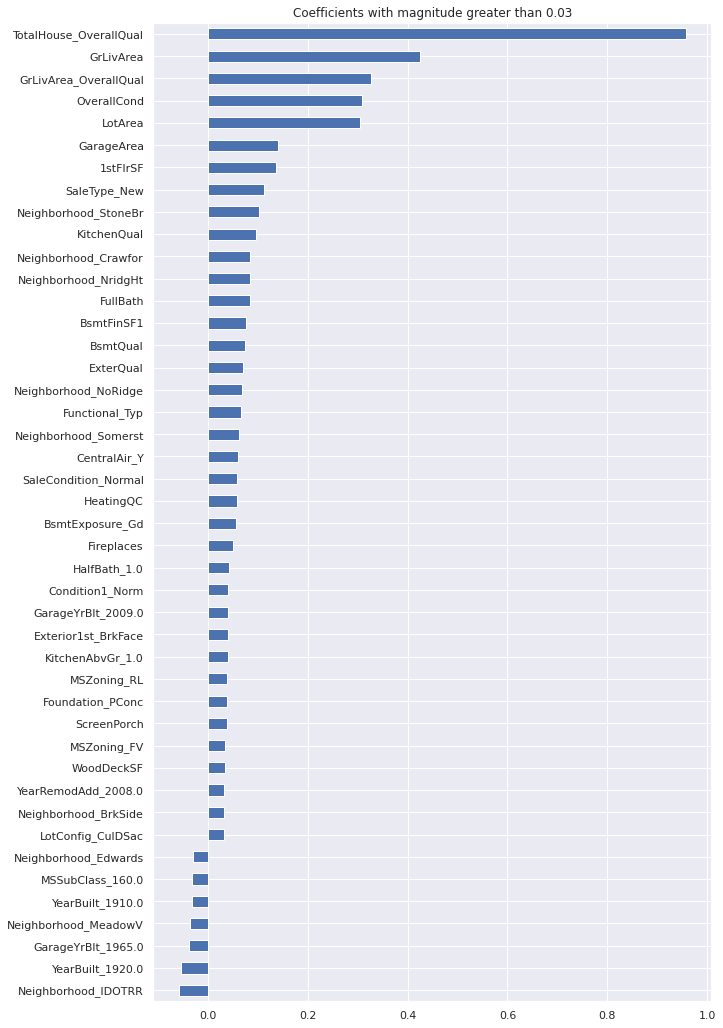

In [41]:
lasso = searchCV.best_estimator_
coefs = pd.Series(lasso.coef_,index=X.columns)

plt.figure(figsize=(10,18))
coefs[coefs.abs()>0.03].sort_values().plot.barh()
plt.title('Coefficients with magnitude greater than 0.03')

## 6.2 Model Submission

In [42]:
y_test_pred = searchCV.predict(X_test)
y_test_pred = np.exp(y_test_pred)
my_submission = pd.DataFrame({'Id': X_test.index.astype(int), 'SalePrice': y_test_pred})
my_submission.to_csv('submission.csv', index=False)

If you found any mistakes or have any tips please be free to comment.